# LGT Model

**LGT** stands for Local and Global Trend, which is an important model type in *orbit* package. In the model equation, there is a local trend term and a global trend term.

$$ y_{t}  = \hat{y}_t + \epsilon $$
$$ \hat{y} = \mu_t + s_t  $$
$$\mu_t = l_{t-1} + \theta b_{t-1} + \xi l_{t-1}^\lambda$$
$$\epsilon_t  ~\sim \mathtt{Student}(\nu, 0, \sigma)$$
$$\sigma ~\sim  \mathtt{HalfCauchy}(0, \gamma_0)$$

where $l_{t-1}, \theta b_{t-1}, \xi l_{t-1}^{\lambda}, s_{t-m}$ and ${\epsilon}_t$ can be viewed as level, local trend, global trend and seasonality respectively. 

In the update process, it follows the triple exponential smoothing form

$$l_t = \rho_l(y_t - s_t) + (1-\rho_l)l_{t-1}$$
$$b_t=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)b_{t-1}$$
$$s_{t+m} =  \rho_s(y_t - l_t ) + (1-\rho_s)s_t$$

where $\rho_l$, $\rho_b$ and $\rho_s$ are the smoothing parameters.  Finally, we fit $\rho_l$, $\rho_b$, $\rho_s$,  $\theta$, $\xi$, $\lambda$, $\nu$ in our training process while $\gamma_0$ is a data-driven scaler.

In orbit, we have three different wrappers for LGT typed models, `LGTMAP`, `LGTAggregated`, `LGTFull`.

**Note: Negative response values are not allowed in LGT model, due to the existence of the global trend term.**

In [1]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims

## Data

First, let's load the example data set, which is the same as the one used in the `quick start` section.

In [2]:
df = load_iclaims()
df["claims"] = np.log(df["claims"])
date_col = 'week'
response_col = 'claims'

In [3]:
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## MAP Fit and Predict

Next, let's instantiate and fit a simple LGT model with the MAP estimation.

In [4]:
lgt=LGTMAP(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=2020,
)

In [5]:
%%time
lgt.fit(df=train_df)

CPU times: user 227 ms, sys: 14 ms, total: 241 ms
Wall time: 527 ms


Now we do the predictions and make the plot about **actual vs fitted**.

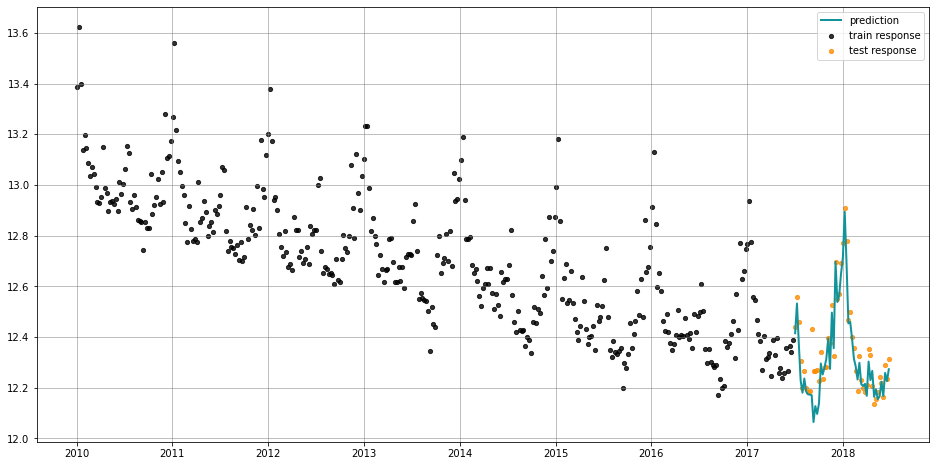

In [6]:
predicted_df = lgt.predict(df=test_df)

plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col,  
                    test_actual_df=test_df)

## MCMC Fit and Predict

Here we instantiate a LGT model with a different inference method, MCMC, and do the model fitting and prediction. We can also use increase `adapt_delta` in the stan setting to reduce divergence.

In [7]:
lgt=LGTFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=2020,
    # default is set as 0.8
    stan_mcmc_control={'adapt_delta':0.85},
)

In [8]:
%%time
lgt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 74.3 ms, sys: 64.2 ms, total: 138 ms
Wall time: 8.14 s


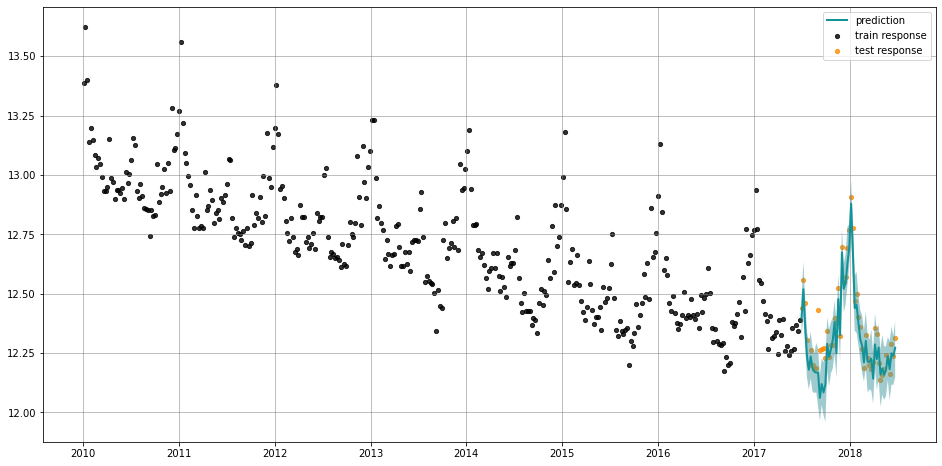

In [9]:
predicted_df = lgt.predict(df=test_df)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt.date_col, actual_col=lgt.response_col, 
                    test_actual_df=test_df)